In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import random
%matplotlib inline
import cv2
import os

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 9s 1us/step


In [3]:
def get_measure_note(thickness = 3, height = 45, width = 10):
    measure_note = np.zeros([height,width])
    length = random.randint(height-3,height)
    measure_note[0:length, int(width/2):int(width/2)+thickness] = 255
    rows,cols = measure_note.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-5,5),random.random()*0.12 + 0.95)
    measure_note = cv2.warpAffine(measure_note,M,(cols,rows))
    measure_note = cv2.GaussianBlur(measure_note,(3,3),0)
    return measure_note

In [4]:
def get_rest_bar(thickness = 3, height = 45, width = 10):
    rest_bar = np.zeros([height,width])
    length = random.randint(43,45)
    rest_bar[int(height/2)-1:int(height/2)+thickness-1, 0:10 - random.randint(0,2)] = 255
    rows,cols = rest_bar.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-4,10),random.random()*0.12 + 0.95)
    rest_bar = cv2.warpAffine(rest_bar,M,(cols,rows))
    rest_bar = cv2.GaussianBlur(rest_bar,(3,3),0)
    return rest_bar

In [5]:
def get_note(last_digit = -1, can_zero=True):
    canvass = np.zeros([45,28])
    index = random.randint(0,x_train.shape[0]-1)
    while y_train[index] > 7 or y_train[index] == last_digit or (not can_zero and y_train[index] == 0):
        index = random.randint(0,x_train.shape[0])
    canvass[4:32,:] = x_train[index]
    label = y_train[index]
    level_vote = random.randint(0,2)
    if level_vote == 0 or label == 0:
        return canvass, label
    
    if level_vote == 1:
        canvass[0:3,12:15] = 255
        canvass[0:5,11:16] = cv2.GaussianBlur(canvass[0:5,11:16],(3,3),0)
        return canvass, label + 10
    
    if level_vote == 2:
        canvass[41:44,12:15] = 255
        canvass[40:44,11:16] = cv2.GaussianBlur(canvass[40:44,11:16],(3,3),0)
        return canvass, label + 20

In [6]:
def get_box(canvass, base_coord=[0,0], show_graph = False):
    top_boundary = 0
    bottom_boundary = canvass.shape[0]-1
    left_boundary = 0
    right_boundary = canvass.shape[1]-1
    for i in range(canvass.shape[1]):
        for j in range(34):
            if canvass[j][i]:
                right_boundary = i
                break
                
    for i in reversed(range(canvass.shape[1])):
        for j in range(34):
            if canvass[j][i]:
                left_boundary = i
                break
    #canvass[top_boundary:bottom_boundary,left_boundary:left_boundary+1] = 255
    #canvass[top_boundary:bottom_boundary,right_boundary-1:right_boundary] = 255
    #canvass[top_boundary:top_boundary+1,left_boundary:right_boundary] = 255
    #canvass[bottom_boundary-1:bottom_boundary,left_boundary:right_boundary] = 255
    if show_graph:
        plt.imshow(canvass)
    return [top_boundary + base_coord[0], left_boundary + base_coord[1], bottom_boundary + base_coord[0], right_boundary + base_coord[1]]

In [7]:
def get_combination(last_digit, simple_version = False):
    #1 * 1/4, 2 * 1/8, 1 * 1/8 + 2 * 1/16,  2 * 1/16 + 1/8, 4 * 1/16 
    index = random.randint(1,5)
    if simple_version:
        index = True
    if index == 1:
        # 1 * 1/4
        seed = random.randint(1,2)
        if seed == 1 and not simple_version and last_digit != -1 and last_digit != 0:
            c = get_rest_bar()
            return c, ['-'], [get_box(c)], last_digit
        c, label =  get_note(last_digit=last_digit)
        return c, [str(label) + "_4"], [get_box(c)], label
    if index == 2:
        # 2 * 1/8
        img1, label1 = get_note(last_digit=last_digit)
        img2, label2 = get_note(label1)
        c = np.hstack((img1, img2))
        c[34:36, 5:55] = 255
        rows = 3
        cols = 51
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-4,4),random.random()*0.12 + 0.95)
        c[34:37, 4:55] = cv2.warpAffine(c[34:37, 4:55],M,(cols,rows))
        return c, [str(label1) + '_8',str(label2) + '_8'], [get_box(img1), get_box(img2,[0, img1.shape[1]])],  label2
        
    if index == 3:
        #2 * 1/16 + 1/8
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        c = np.hstack((img1, img2, img3))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 5:52] = 255
        rows = 8
        cols = c.shape[1] - 9
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(1,3),1)
        c[32:40, 4:c.shape[1]-5] = cv2.warpAffine(c[32:40, 4:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_16',str(label2) + '_16', str(label3) + '_8'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]])], label3
    
    if index == 4:
        #1/8 + 2 * 1/16
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        c = np.hstack((img1, img2, img3))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 35:c.shape[1]-5] = 255
        rows = 8
        cols = c.shape[1] - 9
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(1,3),1)
        c[32:40, 4:c.shape[1]-5] = cv2.warpAffine(c[32:40, 4:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_8',str(label2) + '_16', str(label3) + '_16'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]])], label3
    if index == 5:
        #4 * 1/16
        [img1, label1] = get_note(last_digit=last_digit)
        [img2, label2] = get_note(label1)
        [img3, label3] = get_note(label2)
        [img4, label4] = get_note(label3)
        c = np.hstack((img1, img2, img3, img4))
        c[33:35, 5:c.shape[1]-5] = 255
        c[37:39, 5:c.shape[1]-5] = 255
        rows = 8
        cols = 102
        M = cv2.getRotationMatrix2D((cols/2,rows/2),random.randint(-1,1),1)
        c[31:39, 5:c.shape[1]-5] = cv2.warpAffine(c[32:39, 5:c.shape[1]-5],M,(cols,rows))
        return c, [str(label1) + '_16',str(label2) + '_16', str(label3) + '_16', str(label4) + '_16'],  [get_box(img1), get_box(img2,[0, img1.shape[1]]), get_box(img3,[0, img1.shape[1] + img2.shape[1]]), get_box(img4, [0, img1.shape[1] + img2.shape[1] + img3.shape[1]])], label4

In [8]:
def get_line(max_width, measure_capacity = 2, simple_version = False, try_num = 3):
    canvass, labels, locs, last_digit = get_combination(-1, simple_version=simple_version)
    curr_width = canvass.shape[1]
    remained_measure = measure_capacity - 1
    while True:
        new_canvasses, new_labels, new_locs, last_digit = get_combination(last_digit, simple_version=simple_version)
        for i in range(len(new_locs)):
            new_locs[i][1] += canvass.shape[1]
            new_locs[i][3] += canvass.shape[1]
           
        remained_measure = measure_capacity - 1
        while remained_measure:
            new_canvass, new_label, new_loc, last_digit = get_combination(last_digit, simple_version=simple_version)
            for i in range(len(new_loc)):
                new_loc[i][1] += new_canvasses.shape[1] + canvass.shape[1]
                new_loc[i][3] += new_canvasses.shape[1] + canvass.shape[1]
            new_canvasses = np.hstack((new_canvasses, new_canvass))
            new_locs += new_loc
            new_labels += new_label
            remained_measure -= 1
        
        new_measure_note = get_measure_note()
        new_labels += '|'
        new_loc = get_box(new_measure_note, [0, new_canvasses.shape[1] + canvass.shape[1]])
        new_canvasses = np.hstack((new_canvasses, new_measure_note))
        new_locs += [new_loc]
        if new_canvasses.shape[1] + canvass.shape[1] > max_width:
            if try_num == 0:
                break
            try_num -=1
            continue
        canvass = np.hstack((canvass, new_canvasses))
        labels += new_labels
        curr_width += new_canvass.shape[1]
        locs += new_locs
    canvass = np.hstack((canvass, np.zeros([45, max_width - canvass.shape[1]])))
    return canvass, locs, labels

[[0, 7, 44, 18], [0, 33, 44, 48], [0, 64, 44, 75], [0, 92, 44, 105], [0, 118, 44, 133], [0, 150, 44, 158], [0, 174, 44, 191], [0, 205, 44, 216], [0, 232, 44, 245], [0, 255, 44, 261], [0, 268, 44, 287], [0, 295, 44, 314], [0, 325, 44, 339], [0, 352, 44, 365], [0, 377, 44, 383]]
['17_16', '21_16', '3_16', '21_16', '27_8', '21_16', '0_16', '26_8', '0_8', '|', '2_8', '6_8', '3_8', '7_8', '|']


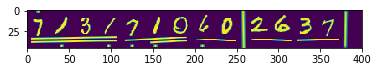

In [9]:
[canvass, locs, labels] = get_line(400)
print(locs)
print(labels)
plt.imshow(canvass)

In [17]:
def get_page(music_sheet_dir, label_dir, max_height, max_width, measure_capacity, inner_line_spacing = 30, show_image = True, simple_version = False):
    canvass, locs, labels = get_line(max_width, measure_capacity, simple_version)
    curr_height = canvass.shape[0]
    while curr_height < max_height:
        new_canvass1 = np.zeros([inner_line_spacing, max_width])
        new_canvass2, new_locs, new_labels = get_line(max_width, measure_capacity, simple_version)
        new_canvass = np.vstack((new_canvass1, new_canvass2))
        if curr_height + new_canvass.shape[0] > max_height:
            break
        for i in range(len(new_locs)):
            new_locs[i][0] += canvass.shape[0]
            new_locs[i][2] += canvass.shape[0]
        canvass = np.vstack((canvass, new_canvass))
        labels += new_labels
        locs += new_locs
        curr_height += new_canvass.shape[0]
    cv2.imwrite(music_sheet_dir, canvass)
    label_array = np.column_stack([np.array(locs), np.array(labels)])
    if show_image:
        plt.imshow(canvass)
    with open(label_dir, 'w') as fp:
        for i in range(len(labels)):
            fp.write(music_sheet_dir + ',' + ','.join(str(e) for e in locs[i]) + ',' + str(labels[i])  + '\n')
    #return canvass, label_array, np.array(locs)

In [29]:
# @label_num_list: List, a list of label file number
# @merged_file_type: String, the type of file to be merged into, will reflected on the file name
# @label_file_dir: String, the directory where label files are stored
# @merged_file_dir: String, the directory to store the merged file
# e.g. ([1,3,5], "test", "./label") will merge label1.txt, label3.txt, label5.txt into "./label/labels_test.txt"
def merge_label(label_num_list, label_file_dir, merged_file_type, merged_file_dir):
    outfile = merged_file_dir + 'labels_' + merged_file_type + '.txt';
    with open(outfile, 'w') as wfd:
        for num in label_num_list:
            fname = label_file_dir + 'label' + str(num) + '.txt'
            with open(fname, 'r') as fd:
                wfd.write(fd.read())

In [30]:
def generate_music_sheet(num, music_sheet_dir, music_label_dir, height, width, simple_version, measure_capacity = 2):
    curr = 0
    if not os.path.isdir(music_sheet_dir):
        os.makedirs(music_sheet_dir)
    if not os.path.isdir(music_label_dir):
        os.makedirs(music_label_dir)
    while curr < num:
        sheet_dir = music_sheet_dir + 'img' + str(curr) + '.png'
        label_dir = music_label_dir + 'label' + str(curr) + '.txt'
        get_page(sheet_dir,label_dir,height,width,measure_capacity, show_image=False, simple_version=simple_version)
        curr += 1
        print('Progress: ' + "{0:.0f}%".format(curr / num * 100) )
    label_num_list = list(range(num))
    merge_label(label_num_list, music_label_dir, 'training', music_label_dir)

In [31]:
generate_music_sheet(10, '../dataset/sheet/training/', '../dataset/label/training/', 600, 400, True)

Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
